# End to end optimised forecast demo
Here we load the trained Aardvark Weather model and produce end-to-end finetuned forecasts at one day lead time for temperature and windspeed. 

In [10]:
import sys
sys.path.append("../aardvark")
import numpy as np
import pickle
from e2e_model import *
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Check a GPU is available

In [11]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available, cannot produce forecast.")

GPU is available.
GPU name: NVIDIA A100 80GB PCIe


## Generate predictions

Load the sample data (for a detailed analysis and visualisation of the contents of this dataset see data_demo.ipynb)

In [12]:
with open('../data/sample_data_final.pkl', 'rb') as fp:
    data = pickle.load(fp)

Load the end to end model. First select which varaible to generate station forecasts for.

In [13]:
local_forecast_var = "tas" # Model weights included for windspeed (ws) and 2tm (tas)

model = ConvCNPWeatherE2E(
                 device="cuda",
                 lead_time=1,
                 se_model_path="../trained_models/encoder",
                 forecast_model_path="../trained_models/processor",
                 sf_model_path=f"../trained_models/decoder/{local_forecast_var}/",
                 return_gridded=False,
                 aux_data_path="../data/"
        )

Load the trained weights

In [14]:
weights_path = f"../trained_models/e2e_finetuned/{local_forecast_var}/"
best_epoch = np.argmin(np.load(weights_path+"losses_0.npy"))
state_dict = torch.load(
    f"{weights_path}/epoch_{best_epoch}", map_location="cuda"
)["model_state_dict"]
state_dict = {k[7:]: v for k, v in zip(state_dict.keys(), state_dict.values())}
model.load_state_dict(state_dict)
model = model.to("cuda")

In [15]:
station_forecast = model(data)

## Visualise model predictions

Plot the station forecasts

In [16]:
STATION_LON_LAT_SF = 360
HADISD_SCALING_FACTOR = 10
# Factors to unnormalise predictions
mean = np.load(f"../data/norm_factors/mean_hadisd_{local_forecast_var}.npy")
std = np.load(f"../data/norm_factors/std_hadisd_{local_forecast_var}.npy")

In [17]:
station_forecast_unnorm = (
    station_forecast.detach().cpu() * std + mean
) * HADISD_SCALING_FACTOR

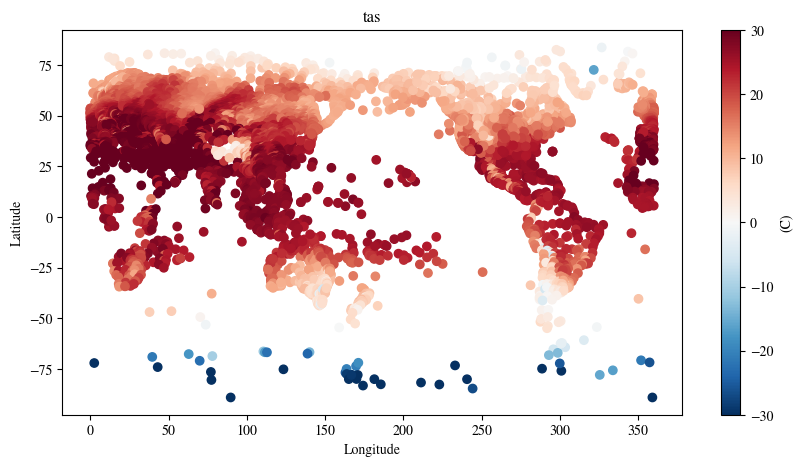

In [18]:
fig = plt.figure(figsize=(10, 5))
plot_channel = 10
p = plt.scatter(
    data["downscaling"]["x_target"][0, 0, :].detach().cpu() * STATION_LON_LAT_SF,
    data["downscaling"]["x_target"][0, 1, :].detach().cpu() * STATION_LON_LAT_SF,
    c=station_forecast_unnorm[0, :],
    vmax=30,
    vmin=-30,
    cmap="RdBu_r",
)
cbar = fig.colorbar(p)
cbar.set_label("(C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"{local_forecast_var}")
plt.show()